## Hospital Cost and Quality

Wen Zhang

### Table of Contents

1. [Goal](#1.-Goal)
2. [Description of Datasets](#2.-Description-of-Datasets)
3. [Data Processing](#3.-Data-Processing)  
    3.1 [Load Data](#3.1-Load-Data)  
    3.2 [Clean Data](#3.2-Clean-Data)  
    3.3 [Choose Target Variables](#3.3-Choose-Target-Variables)  
    3.4 [Merge Datasets](#3.4-Merge-Datasets)  
    3.5 [Rescale Payments](#3.5-Rescale-Payments)  
4. [Exploratory Data Analysis](#4.-Exploratory-Data-Analysis)  
    4.1 [Distribution of Variables and Measures](#4.1-Distribution-of-Variables-and-Measures)  
    4.2 [Cost and Unplanned Hospital Visits](#4.2-Cost-and-Unplanned-Hospital-Visits)  
    4.3 [Cost and 30-Day Mortality Rate](#4.3-Cost-and-30-Day-Mortality-Rate)  
    4.4 [Cost and Timely and Effective Measures](#4.4-Cost-and-Timely-and-Effective-Measures)  
5. [Modeling](#5.-Modeling)  
    5.1 [Simple Linear Regression](#5.1-Simple-Linear-Regression)  
    5.2 [Multiple Linear Regression](#5.2-Multiple-Linear-Regression)  
6. [Results and Discussion](#6.-Results-and-Discussion)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from regression_helper import plot_univariate_smooth
plt.rcParams['figure.figsize'] = (14, 6)

/Users/wen/code/pylearn/venv3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 1. Goal

To identify the relationship of the cost and the quality of cardiac services in the United States. 

Heart failure and heart attack are two forms of heart disease. They have some common causes. Heart attacks can lead to heart failure by weakening the heart's pumping ability. I will investigate into both heart failure and heart attack treatment and services in this analysis. 

### 2. Description of Datasets

In order identify the relationship of cost and quality, I will need the data of cost/payments and outcome measures. I searched in the CMS database and found several datasets that will help. All of these datasets contains the information of the same hospitals registered at CMS and have similar time frames (except for Timely and Effective Care Dataset). The outcome measures could be found in Unplanned Hospital Visits - Hospital, Complications and Deaths - Hospital, and Timely and Effective Care - Hospital datasets. The corresponding payments data could be found in Payment and Value of Care. Other hospital information could be found in  Hospital General Information. 

* **Hospital General Information** 
    * A list of all Hospitals that have been registered with Medicare. The list includes addresses, phone numbers, and hospital type.
    * \# of Hospitals: 4806
    

* **Payment and Value of Care**
    * Payment: The payment measures add up the payments for care starting the day the patient enters the hospital and continuing for the next 30 days (or 90-day for hip/knee replacement).
    * The death rates look at deaths in the first 30 days after the patient is hospitalized for a heart attack, heart failure, or pneumonia. 
    * Time window: 2013-04-01 to 2016-06-30
    * \# of Hospitals: 4806

    
* **Unplanned Hospital Visits - Hospital**  
    https://www.medicare.gov/hospitalcompare/Data/Hospital-returns.html
    * This data set includes provider data for the hospital return days (or excess days in acute care) measures, the unplanned readmissions measures, and the rate of unplanned hospital visits after an outpatient colonoscopy.
    * The lower score, the better
    * Time window: 2013-07-01 to 2016-12-31
    * \# of Hospitals: 4806
    

* **Complications and Deaths - Hospital**
    *  This data set includes provider data for the hip/knee complication measure, the Agency for Healthcare Research and Quality (AHRQ) measures of serious complications, and 30-day death rates.
    * Time window: 2013-04-01 to 2016-06-30
    * \# of Hospitals: 4806
    
    
* **Timely and Effective Care - Hospital**
    * This data set includes provider-level data for measures of heart attack care, heart failure care, pneumonia care, surgical care, emergency department care, preventive care, children’s asthma care, blood clot prevention and treatment, pregnancy and delivery care, and cancer care.
    * Time window: 2016-01-01 to 2017-03-31
    * \# of Hospitals: 4806


### 3. Data Processing

11 outcome measures related to cardiac services will be selected from three datasets. The measures can be grouped into three groups: unplanned hospital visits (#4), mortality (#2), and timely and effective care (#5). Both outcome measures of heart failure (#3) and heart attack (#8) are included. 

#### 3.1 Load Data

In [2]:
general_df = pd.read_csv('data/Hospital_General_Information.csv')
payment_df = pd.read_csv('data/Payment_and_value_of_care_-_Hospital.csv',
                         parse_dates=['Measure start date', 'Measure End Date'])
unplanned_visit_df = pd.read_csv('data/Unplanned_Hospital_Visits_-_Hospital.csv',
                                 parse_dates=['Measure Start Date', 'Measure End Date'])
compl_mort_df = pd.read_csv('data/Complications_and_Deaths_-_Hospital.csv',
                            parse_dates=['Measure Start Date', 'Measure End Date'])
time_effective_df = pd.read_csv('data/Timely_and_Effective_Care_-_Hospital.csv',
                                parse_dates=['Measure Start Date', 'Measure End Date'])

#### 3.2 Clean Data

Check the type of each variables and change the data type correspondingly. 

In [3]:
columns_to_keep = ['Provider ID', 'Hospital Name', 'Address', 'City', 'State',
                   'ZIP Code', 'County Name', 'Hospital Type', 'Hospital Ownership',
                   'Emergency Services']
hospitals_df = general_df[columns_to_keep]

In [4]:
payment_df['Payment'] = payment_df['Payment'].str.replace(',', '')
payment_df['Payment'] = payment_df['Payment'].str.replace('$', '')
payment_df['Payment'].replace('Not Available', np.nan, inplace=True)
payment_df['Payment'] = payment_df['Payment'].astype(float)

In [5]:
def transfer_denominator(dataframe):
    dataframe['Denominator'] = dataframe['Denominator'].str.replace(',', '')
    dataframe['Denominator'].replace('Not Available', np.nan, inplace=True)
    dataframe['Denominator'] = dataframe['Denominator'].astype(float)
    return dataframe

In [6]:
def transfer_score(dataframe):
    dataframe['Score'].replace('Not Available', np.nan, inplace=True)
    dataframe['Score'] = dataframe['Score'].astype(float)
    return dataframe

In [7]:
df_list = [payment_df, unplanned_visit_df, compl_mort_df]
for df in df_list:
    if 'Score' in df.columns:
        transfer_score(df)
    if 'Denominator' in df.columns:
        transfer_denominator(df)

#### 3.3 Choose Target Variables

In [8]:
# select payment for heart failure and heart attack patients. 
# Heart attack is also known as Acute Myocardial Infarction (AMI)
payment_HF_df = payment_df[payment_df['Payment measure ID']=='PAYM_30_HF']
payment_AMI_df = payment_df[payment_df['Payment measure ID']=='PAYM_30_AMI']

In [9]:
# select unplanned hospital visits (excess days in acute care and readmission rate) related to heart failure
cols = ['Provider ID','Denominator',  'Compared to National', 'Score']
EDAC_30_HF_df = unplanned_visit_df.loc[unplanned_visit_df['Measure ID']=='EDAC_30_HF', cols]
READM_30_HF_df = unplanned_visit_df.loc[unplanned_visit_df['Measure ID']=='READM_30_HF', cols]
EDAC_30_AMI_df = unplanned_visit_df.loc[unplanned_visit_df['Measure ID']=='EDAC_30_AMI', cols]
READM_30_AMI_df = unplanned_visit_df.loc[unplanned_visit_df['Measure ID']=='READM_30_AMI', cols]

In [10]:
# select Heart failure (HF) 30-Day Mortality Rate and AMI 30-day Mortality Rate
cols = ['Provider ID','Denominator', 'Compared to National', 'Score']
MORT_30_HF_df = compl_mort_df.loc[compl_mort_df['Measure ID']== 'MORT_30_HF', cols]
MORT_30_AMI_df = compl_mort_df.loc[compl_mort_df['Measure ID']== 'MORT_30_AMI', cols]

In [11]:
# subselect timely and effective measures related to heart attack
time_effective_AMI_df = time_effective_df.loc[time_effective_df['Condition']=='Heart Attack or Chest Pain', 
                                              ['Provider ID','Measure ID', 'Measure Name', 'Score', 'Sample']]

In [12]:
time_effective_AMI_df['Score'].replace('Not Available', np.nan, inplace=True)
time_effective_AMI_df['Score'] = time_effective_AMI_df['Score'].astype(float)
time_effective_AMI_df['Sample'].replace('Not Available', np.nan, inplace=True)
time_effective_AMI_df['Sample'] = time_effective_AMI_df['Sample'].astype(float)

In [13]:
MTECG_AMI_df = time_effective_AMI_df[time_effective_AMI_df['Measure Name']=='Median Time to ECG']
MTFB_AMI_df = time_effective_AMI_df[time_effective_AMI_df['Measure Name']=='Median Time to Fibrinolysis']
FBED_AMI_df = time_effective_AMI_df[time_effective_AMI_df['Measure Name']=='Fibrinolytic Therapy Received Within 30 Minutes of ED Arrival']
MTACI_AMI_df = time_effective_AMI_df[time_effective_AMI_df['Measure Name']=='Median Time to Transfer to Another Facility for Acute Coronary Intervention']
APA_AMI_df = time_effective_AMI_df[time_effective_AMI_df['Measure Name']=='Aspirin at Arrival']

#### 3.4 Merge Datasets 

Create one big dataframe containing payments, outcome measures and general attributes of hospitals.

In [14]:
cols = ['Provider ID', 'Payment', 'Denominator']
payment_HF_df = payment_HF_df[cols].set_index('Provider ID', drop=True).sort_index()
payment_HF_df.columns=['Payment_HF', 'Denominator_HF']
payment_AMI_df = payment_AMI_df[cols].set_index('Provider ID', drop=True).sort_index()
payment_AMI_df.columns=['Payment_AMI', 'Denominator_AMI']
hospitals_df = hospitals_df.set_index('Provider ID', drop=True).sort_index()
hospitals_df = pd.concat([hospitals_df, payment_HF_df, payment_AMI_df], axis=1)

In [15]:
scores = {
    'EDAC_30_HF': EDAC_30_HF_df,
    'READM_30_HF': READM_30_HF_df,
    'EDAC_30_AMI': EDAC_30_AMI_df,
    'READM_30_AMI': READM_30_AMI_df,
    'MORT_30_HF': MORT_30_HF_df,
    'MORT_30_AMI': MORT_30_AMI_df,
    'MTECG_AMI': MTECG_AMI_df,
    'MTFB_AMI': MTFB_AMI_df,
    'FBED_AMI': FBED_AMI_df,
    'MTACI_AMI': MTACI_AMI_df,
    'APA_AMI': APA_AMI_df,
}
for name, df in scores.items():
    df = df.set_index('Provider ID', drop=True).sort_index()
    df = df[['Score']].rename(columns={'Score': name})
    hospitals_df = pd.concat([hospitals_df, df], axis=1)

In [16]:
hospitals_df.columns

Index(['Hospital Name', 'Address', 'City', 'State', 'ZIP Code', 'County Name',
       'Hospital Type', 'Hospital Ownership', 'Emergency Services',
       'Payment_HF', 'Denominator_HF', 'Payment_AMI', 'Denominator_AMI',
       'EDAC_30_HF', 'READM_30_HF', 'EDAC_30_AMI', 'READM_30_AMI',
       'MORT_30_HF', 'MORT_30_AMI', 'MTECG_AMI', 'MTFB_AMI', 'FBED_AMI',
       'MTACI_AMI', 'APA_AMI'],
      dtype='object')

#### 3.5 Rescale Payments

The original scale of payments (12,000   to  30,000) is too large compared to outcome measures (-10 to 200). I devided the payments by 1000 to make them comparable. 

In [17]:
hospitals_df['Payment_HF'] = hospitals_df['Payment_HF'] / 1000
hospitals_df['Payment_AMI'] = hospitals_df['Payment_AMI'] / 1000

### 4. Exploratory Data Analysis

I visualized distribution and pair-wise correlation of all variables. More closer look were taken at the relationship between payments and outcome measures. 

#### 4.1 Distribution of Variables

Visualization of all the variables (both independent and dependant variables) will be applied to check the distribution and pair-wise correlation. Here I only showed the process to do scatter matrix related to mortality measures. The other two matrix (unplanned visits and timely and effectively) were also applied but were not displayed here. 

In [18]:
# Factorize categorical variables
type_dict = {'Acute Care Hospitals': 1, 'Critical Access Hospitals': 2, 'Childrens': 3}
hospitals_df.loc[:, ['Hospital Type']] = hospitals_df['Hospital Type'].map(type_dict)

In [20]:
owner_dict = {
    'Voluntary non-profit - Private': 1,
    'Proprietary': 2,
    'Government - Hospital District or Authority':3,
    'Voluntary non-profit - Other': 1,
    'Government - Local': 3,
    'Voluntary non-profit - Church':1,
    'Physician': 4,
    'Government - State':3,
    'Government - Federal': 3,
    'Tribal': 4
}
hospitals_df.loc[:, ['Hospital Ownership']] = hospitals_df['Hospital Ownership'].map(owner_dict)

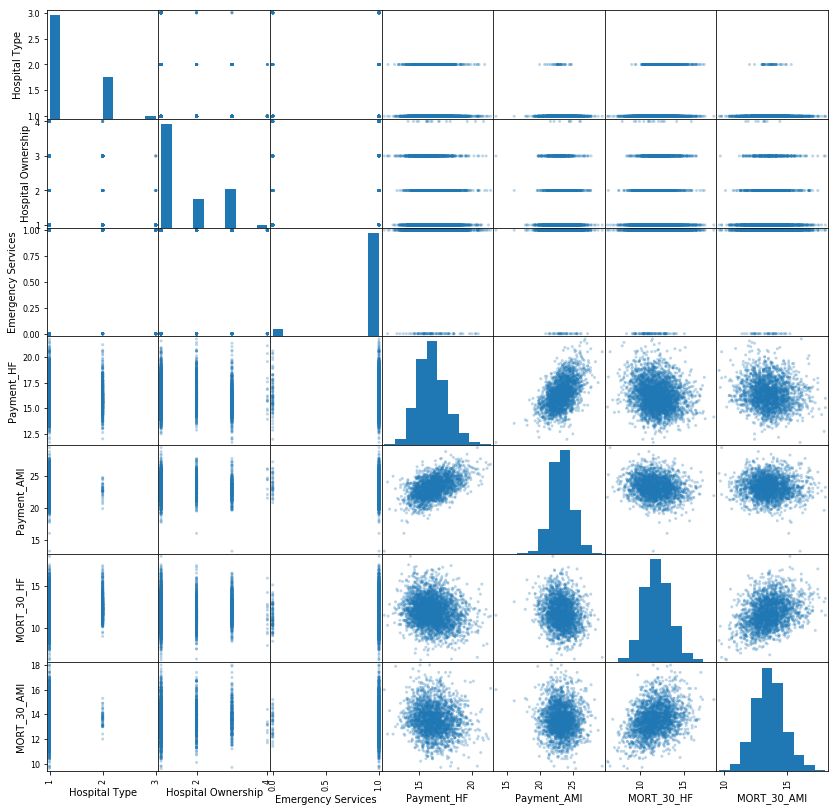

In [25]:
cols = ['Hospital Type', 'Hospital Ownership', 'Emergency Services',
        'Payment_HF', 'Payment_AMI', 'MORT_30_HF' , 'MORT_30_AMI']
scatter_matrix(hospitals_df[cols], alpha=0.3, figsize=(14, 14))
plt.show()

#### Oberservations:  

* Payments in both heart failure patients and heart attack patients are normally distributed. 
* Measures of unplanned hospital visit and mortality rate are normally distributed. While distributions of time and effective measures in heart attack deparment are all skewed. 
* There seems to be no obvious linear relationship between hospital attributes and quality measures.
* There seems to be no obvious linear relationship between payments and quality measures.
* Payments of heart failure and heart attack seems to be highly correlated.
* Outcome measures themselves seem to be correlated with each other. 

#### 4.2 Cost and Unplanned Hospital Visits

/Users/wen/code/pylearn/venv3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


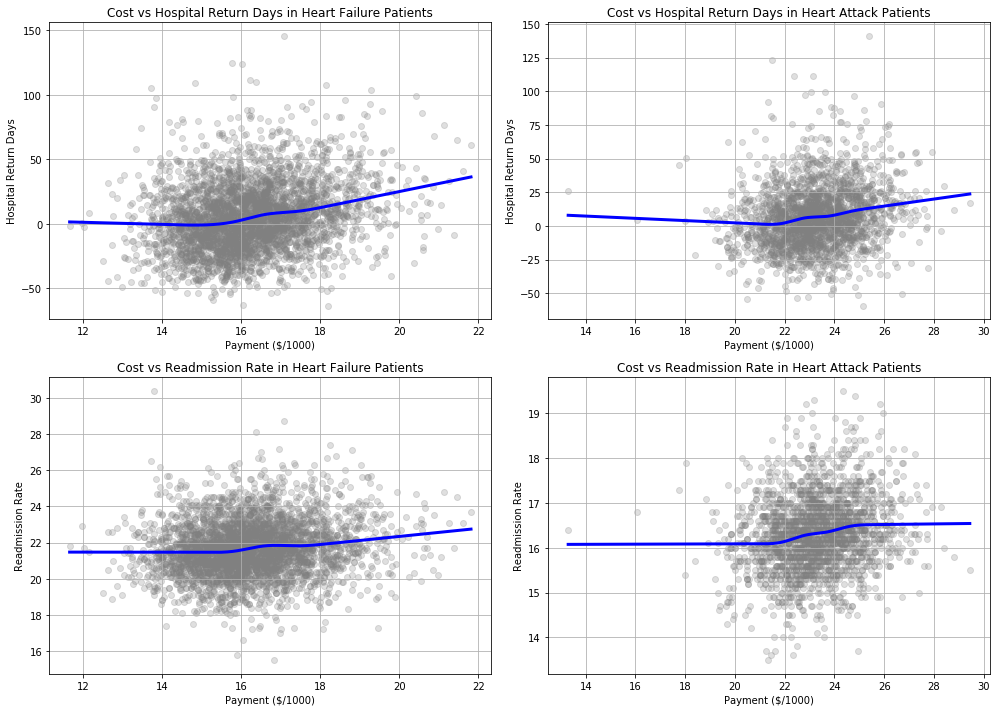

In [28]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(figsize=(14,10), nrows=2, ncols=2)

index = hospitals_df['EDAC_30_HF'].notnull() & hospitals_df['Payment_HF'].notnull()
plot_univariate_smooth(ax11, hospitals_df.loc[index, 'Payment_HF'], hospitals_df.loc[index, 'EDAC_30_HF'])
ax11.set_ylabel('Hospital Return Days')
ax11.set_xlabel('Payment ($/1000)')
ax11.set_title('Cost vs Hospital Return Days in Heart Failure Patients')
ax11.grid(True)

index = hospitals_df['EDAC_30_AMI'].notnull() & hospitals_df['Payment_AMI'].notnull()
plot_univariate_smooth(ax12, hospitals_df.loc[index, 'Payment_AMI'], hospitals_df.loc[index, 'EDAC_30_AMI'])
ax12.set_ylabel('Hospital Return Days')
ax12.set_xlabel('Payment ($/1000)')
ax12.set_title('Cost vs Hospital Return Days in Heart Attack Patients')
ax12.grid(True)

index = hospitals_df['READM_30_HF'].notnull() & hospitals_df['Payment_HF'].notnull()
plot_univariate_smooth(ax21, hospitals_df.loc[index, 'Payment_HF'], hospitals_df.loc[index, 'READM_30_HF'])
ax21.set_xlabel('Payment ($/1000)')
ax21.set_ylabel('Readmission Rate')
ax21.set_title('Cost vs Readmission Rate in Heart Failure Patients')
ax21.grid(True)

index = hospitals_df['READM_30_AMI'].notnull() & hospitals_df['Payment_AMI'].notnull()
plot_univariate_smooth(ax22, hospitals_df.loc[index, 'Payment_AMI'], hospitals_df.loc[index, 'READM_30_AMI'])
ax22.set_xlabel('Payment ($/1000)')
ax22.set_ylabel('Readmission Rate')
ax22.set_title('Cost vs Readmission Rate in Heart Attack Patients')
ax22.grid(True)

fig.tight_layout()

For heart failure patients, there seems to be weak association between cost and readmission rate and also hospital return days. As the payments increase, both the hospital return days and readmission rate increase. While for heart attack patients, the relationship is not obvious. 

#### 4.3 Cost and 30-Day Mortality Rate

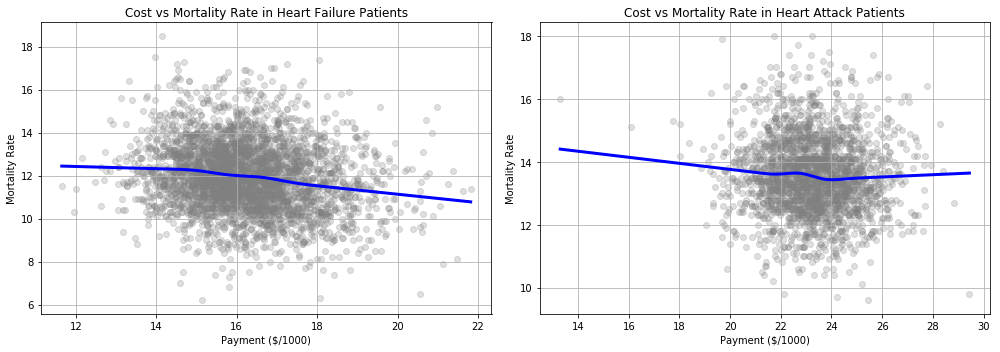

In [29]:
fig, axes=plt.subplots(figsize=(14,5), nrows=1, ncols=2)

index = hospitals_df['MORT_30_HF'].notnull() & hospitals_df['Payment_HF'].notnull()
plot_univariate_smooth(axes[0], hospitals_df.loc[index, 'Payment_HF'], hospitals_df.loc[index, 'MORT_30_HF'])
axes[0].set_ylabel('Mortality Rate')
axes[0].set_xlabel('Payment ($/1000)')
axes[0].set_title('Cost vs Mortality Rate in Heart Failure Patients')
axes[0].grid(True) 

index = hospitals_df['MORT_30_AMI'].notnull() & hospitals_df['Payment_AMI'].notnull()
plot_univariate_smooth(axes[1], hospitals_df.loc[index, 'Payment_AMI'], hospitals_df.loc[index, 'MORT_30_AMI'])
axes[1].set_ylabel('Mortality Rate')
axes[1].set_xlabel('Payment ($/1000)')
axes[1].set_title('Cost vs Mortality Rate in Heart Attack Patients')
axes[1].grid(True)

fig.tight_layout()

Based on the plot, there seems to be weak association between cost and mortality rate in heart failure patients. while in heart attack patients, the association is not very obvious.

#### 4.4 Cost and Timely and Effective Measures

In [30]:
time_effective_AMI_df.set_index('Provider ID', inplace=True)
time_effective_AMI_df.sort_index(inplace=True)

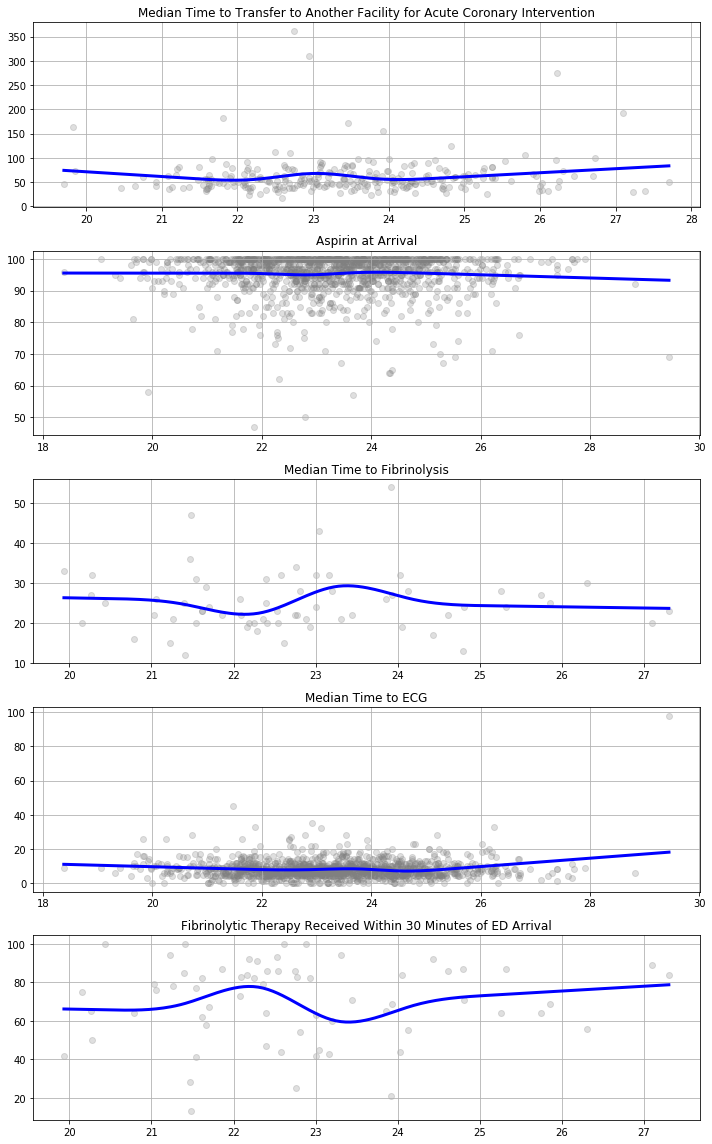

In [650]:
# TODO: refactor
fig, axes = plt.subplots(figsize=(10,16), nrows=time_effective_AMI_df['Measure Name'].nunique(), ncols=1)
for measure, ax in zip(time_effective_AMI_df['Measure Name'].unique(), axes):
    index = payment_AMI_df['Payment'].notnull()  & time_effective_AMI_df.loc[time_effective_AMI_df['Measure Name']==measure, 'Score'].notnull()
    plot_univariate_smooth(ax, payment_AMI_df['Payment'][index], 
                           time_effective_AMI_df.loc[time_effective_AMI_df['Measure Name']==measure, 'Score'][index])
    ax.set_title('{}'.format(measure))
    ax.grid(True)
fig.tight_layout()

Based on the plot, there is no obvious association between cost and any time and effective measures in heart attack patients. 

### 5. Modeling

Here I will build simple linear regression model to investigate the margin impact of cost on these 11 outcome measures related to cardiac services. I will also build multiple linear regression model to control the impact of hospitals attributes and number of patients on the outcome measures. 

I only showed the result of readmission rate in heart failure patients. I followed the same procedure for 10 other measures. 

#### 5.1 Simple Linear Regression

In [32]:
def summary_model(X, y, label='scatter'):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    summary = model.summary()
    return summary

def plot_model(X, y, label='Residual Plot'):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    student_resids = model.outlier_test()['student_resid']
    y_hats = model.predict(X)
    plt.scatter(y_hats, student_resids, alpha = .35, label=label)
    plt.legend()
    plt.show()

In [33]:
index = hospitals_df['READM_30_HF'].notnull() & hospitals_df['Payment_HF'].notnull()
summary_model(hospitals_df.loc[index, 'Payment_HF'], hospitals_df.loc[index, 'READM_30_HF'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            READM_30_HF   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     63.69
Date:                Tue, 20 Feb 2018   Prob (F-statistic):           1.95e-15
Time:                        22:28:09   Log-Likelihood:                -6446.0
No. Observations:                3523   AIC:                         1.290e+04
Df Residuals:                    3521   BIC:                         1.291e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.2951      0.299     64.507      0.000      18.709      19.882
Payment_HF     0.1466      0.018      7.981      0.000       0.111       0.183
==============================================================================
Omnibus:                      127.648   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.902
Skew:                           0.319   Prob(JB):                     4.34e-46
Kurtosis:                       4.008   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

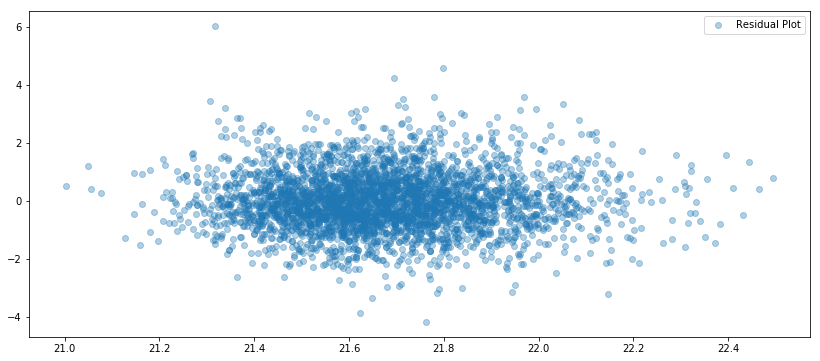

In [36]:
plot_model(hospitals_df.loc[index, 'Payment_HF'], hospitals_df.loc[index, 'READM_30_HF'], label='Residual Plot')

#### 5.2 Multiple Linear Regression

In [39]:
# Get the Dummy variables
type_dummy = pd.get_dummies(hospitals_df['Hospital Type'])
# Only need two of the three values
hospitals_df[['Acute Care Hospitals', 'Critical Access Hospitals']] = type_dummy[ [1, 2] ]

In [40]:
# Get the Dummy variables
owner_dummy = pd.get_dummies(hospitals_df['Hospital Ownership'])
# Only need three of the four values
hospitals_df[['Voluntary non-profit', 'Proprietary', 'Government']] = owner_dummy[ [1, 2, 3] ]

In [52]:
X = hospitals_df[['Acute Care Hospitals', 'Critical Access Hospitals', 
                  'Voluntary non-profit', 'Proprietary', 'Government',
                  'Denominator_HF', 'Payment_HF']]
y = hospitals_df['READM_30_HF']

index = hospitals_df['Denominator_HF'].notnull() & hospitals_df['Payment_HF'].notnull() & hospitals_df['READM_30_HF'].notnull()
X = X[index]
y = y[index]

summary_model(X, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            READM_30_HF   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     23.93
Date:                Wed, 21 Feb 2018   Prob (F-statistic):           6.74e-28
Time:                        13:13:40   Log-Likelihood:                -6407.1
No. Observations:                3523   AIC:                         1.283e+04
Df Residuals:                    3516   BIC:                         1.287e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.5205      0.320     39.180      0.000      11.894      13.147
Acute Care Hospitals          6.3444      0.161     39.504      0.000       6.029       6.659
Critical Access Hospitals     6.1762      0.167     36.991      0.000       5.849       6.504
Voluntary non-profit          0.3539      0.364      0.973      0.331      -0.359       1.067
Proprietary                   0.8727      0.367      2.376      0.018       0.152       1.593
Government                    0.5624      0.367      1.531      0.126      -0.158       1.283
Denominator_HF               -0.0003      0.000     -2.577      0.010      -0.000   -6.49e-05
Payment_HF                    0.1499      0.019      7.928      0.000       0.113       0.187
==============================================================================
Omnibus:                      141.505   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.377
Skew:                           0.352   Prob(JB):                     2.56e-50
Kurtosis:                       4.030   Cond. No.                     5.28e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.74e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 6. Results and Discussion

The cost impact on unplanned hospital visits and mortality are significant before and after controlling hospital attributes. For unplanned hospital visits, as the cost increases, both the readmission rates and hospital return days increase. While for mortality, as the cost increases, the mortality decreases. This indicates a mixed effect of cost on quality of cardiac services.   

While the impact on timely and effective measures in heart attack patients is not significant. There are two possible explanations: 1) Comparatively small sample sizes; 2) The payments data were collected earlier than the timely and effective measures.

It's still too harsh to come to conclusion. Some other confoundings have not be controlled, namely the severity of illness. As severe patients tend to cost more while come to worse outcome. Hospitals, espacially advanced ones, usually have more severe patients, resulting in more cost and low quality. 

Lastly, the timeframe of our data is too wide. The conclusion is weakened and biased as the payments and measures will change from time to time. More time specified data, like year-to-year data will increase the validity and reliability of our analysis. 
